In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
%matplotlib inline

In [3]:
def level_up(n, base, increment):
    x = range(n)
    df = pd.DataFrame({
        "level" : x,
        "stat" : [base+(increment*i) for i in range(n)]
    })
    return(df)

Load yesterday's data

In [4]:
# Load data
dat = pd.read_csv("lol_base_stats.tsv", sep="\t")
dat.head()

,Champions,HP,HP+,HP5,HP5+,MP,MP+,MP5,MP5+,AD,AD+,AS,AS+,AR,AR+,MR,MR+,MS,Range,href
0,Aatrox,537.80,85.0,6.590,0.50,100.00,0.0,0.00,0.000,60.3760,3.20,0.651,0.03000,24.384,3.8,32.1,1.25,345.0,150.0,http://leagueoflegends.wikia.com/wiki/Aatrox
1,Ahri,514.40,80.0,6.505,0.60,334.00,50.0,6.00,0.800,53.0400,3.00,0.668,0.02000,20.880,3.5,30.0,0.00,330.0,550.0,http://leagueoflegends.wikia.com/wiki/Ahri
2,Akali,587.80,85.0,8.340,0.65,200.00,0.0,50.00,0.000,58.3760,3.20,0.694,0.03100,26.380,3.5,32.1,1.25,350.0,125.0,http://leagueoflegends.wikia.com/wiki/Akali
3,Alistar,613.36,106.0,8.675,0.85,278.84,38.0,8.50,0.800,61.1116,3.62,0.625,0.02125,24.380,3.5,32.1,1.25,330.0,125.0,http://leagueoflegends.wikia.com/wiki/Alistar
4,Amumu,613.12,84.0,8.875,0.85,287.20,40.0,7.38,0.525,53.3840,3.80,0.638,0.02180,23.544,3.8,32.1,1.25,335.0,125.0,http://leagueoflegends.wikia.com/wiki/Amumu


### Add class data
Continue scraping the web to add primary role

In [5]:
from bs4 import BeautifulSoup
import requests

primary_role = []
for url in dat.href:
    html_data = requests.get(url).text
    soup = BeautifulSoup(html_data, "html5lib")
    
    role = soup.find('div', attrs={'class' : 'champion_info'}).table.a.text
    primary_role.append(role)

In [6]:
dat["primary_role"] = primary_role
dat.head()

,Champions,HP,HP+,HP5,HP5+,MP,MP+,MP5,MP5+,AD,...,AS,AS+,AR,AR+,MR,MR+,MS,Range,href,primary_role
0,Aatrox,537.80,85.0,6.590,0.50,100.00,0.0,0.00,0.000,60.3760,...,0.651,0.03000,24.384,3.8,32.1,1.25,345.0,150.0,http://leagueoflegends.wikia.com/wiki/Aatrox,Fighter
1,Ahri,514.40,80.0,6.505,0.60,334.00,50.0,6.00,0.800,53.0400,...,0.668,0.02000,20.880,3.5,30.0,0.00,330.0,550.0,http://leagueoflegends.wikia.com/wiki/Ahri,Mage
2,Akali,587.80,85.0,8.340,0.65,200.00,0.0,50.00,0.000,58.3760,...,0.694,0.03100,26.380,3.5,32.1,1.25,350.0,125.0,http://leagueoflegends.wikia.com/wiki/Akali,Slayer
3,Alistar,613.36,106.0,8.675,0.85,278.84,38.0,8.50,0.800,61.1116,...,0.625,0.02125,24.380,3.5,32.1,1.25,330.0,125.0,http://leagueoflegends.wikia.com/wiki/Alistar,Tank
4,Amumu,613.12,84.0,8.875,0.85,287.20,40.0,7.38,0.525,53.3840,...,0.638,0.02180,23.544,3.8,32.1,1.25,335.0,125.0,http://leagueoflegends.wikia.com/wiki/Amumu,Tank


In [79]:
# Save data
dat.to_csv("lol_base_stats-roles.tsv", index=False, sep="\t")

In [8]:
# Define colors
my_colors = ['b', 'r', 'm', 'g', 'k', 'y']
my_colors_key = {
    'Controller' : 'b',
    'Fighter' : 'r',
    'Mage' : 'm',
    'Marksman' : 'g',
    'Slayer' : 'k',
    'Tank' : 'y'
}

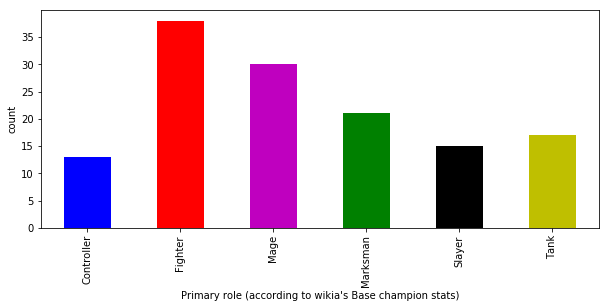

In [9]:
plt.rcParams["figure.figsize"] = [10,4]

# How many champions of each type?
dat.groupby(["primary_role"]).count()["Champions"].plot.bar(color=my_colors)
plt.ylabel("count")
plt.xlabel("Primary role (according to wikia's Base champion stats)")

### Visualizing high-dimensional data

In [11]:
# Use only complete cases
datc = pd.DataFrame.dropna(dat)
datc = datc.iloc[:, 1:-2]

### t-distributed Stochastic Neighbor Embedding (TSNE)

> [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

- More information provdied by Laurens van der Maaten (https://lvdmaaten.github.io/tsne/)

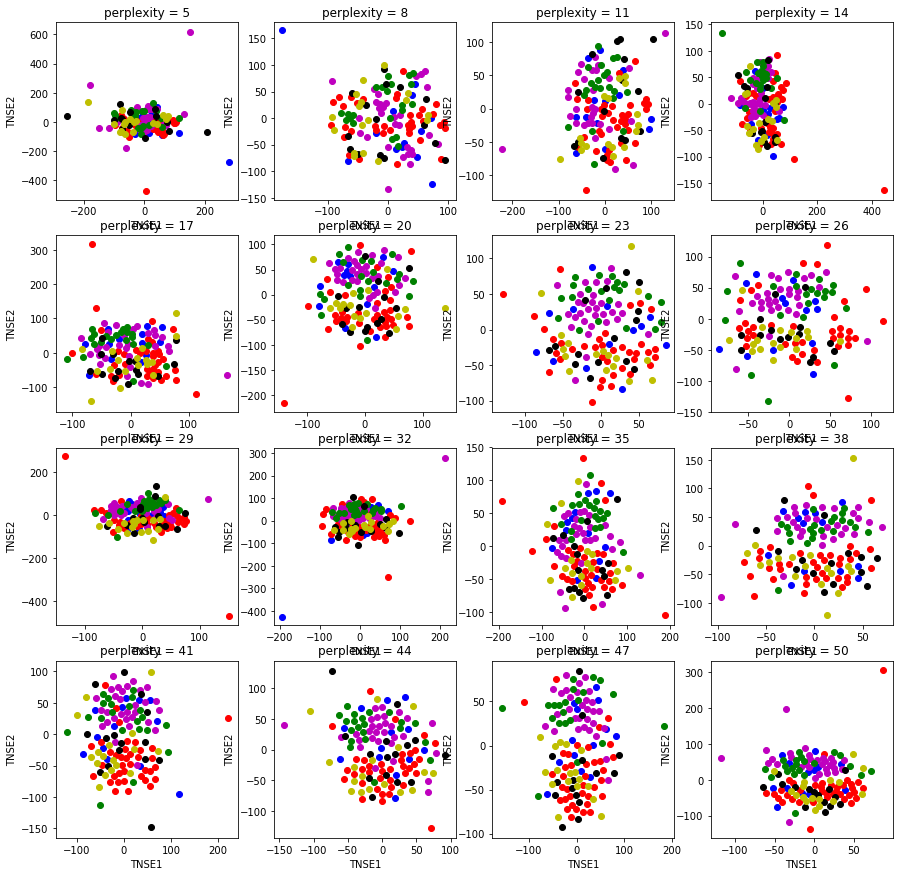

In [14]:
# Plot t-SNE at different perplexities

plt.rcParams["figure.figsize"] = [15,15]
nrows = 4
ncols = 4
fig, ax = plt.subplots(nrows, ncols)

perplexity = list(range(50, 4, -3))
    
for i in range(nrows):
    for j in range(ncols):
        
        p = perplexity.pop()    
        
        # Run TSNE
        model = TSNE(n_components=2, perplexity=p, random_state=0)
        X = model.fit_transform(datc)
        
        xlabel = "TNSE1"
        ylabel = "TNSE2"

        for k in my_colors_key.keys():
            X_subset = X[dat.dropna()["primary_role"] == k,]
            x = X_subset[:,0]
            y = X_subset[:,1]
            ax[i,j].scatter(x, y, color=my_colors_key[k])

        ax[i,j].title.set_text("perplexity = {}".format(p))
        ax[i,j].set(xlabel=xlabel, ylabel=ylabel)

### Principal component analysis (PCA)
PCA, another dimensionality reduction algorithm.

> Principal component analysis (PCA) is a technique used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize ([Victor Powell](http://setosa.io/ev/principal-component-analysis/))

[<matplotlib.text.Text at 0x110fed978>, <matplotlib.text.Text at 0x111a5ca20>]

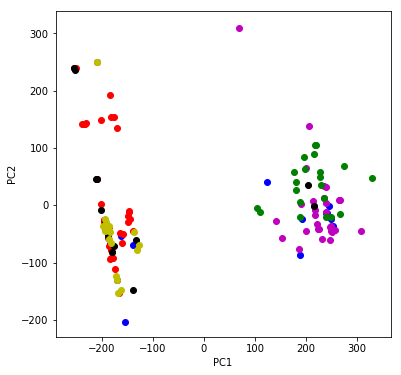

In [15]:
plt.rcParams["figure.figsize"] = [6,6]

fig, ax = plt.subplots(1, 1)

# Run PCA
pca = PCA(n_components=2)
pca.fit(datc)
X = pca.transform(datc)

xlabel = "PC1"
ylabel = "PC2"

for k in my_colors_key.keys():
    X_subset = X[dat.dropna()["primary_role"] == k,]
    x = X_subset[:,0]
    y = X_subset[:,1]
    ax.scatter(x, y, color=my_colors_key[k])

ax.set(xlabel=xlabel, ylabel=ylabel)